# Overview: The target variable is distinguishing which class the car condition belongs to. 
It is a multi-class classification problem

## The following is the workflow for devising a model that predicts these well based on the performance metric chosen

1. Data Cleaning, Exploration and Visualization
2. Split the data into train- test
3. Feature Scaling and data treatment
4. Select a performance measure 
5. Finalize the model algorithm using nested CV
6. Fine tune the hyper parameters of the selected algorithm to finalize the model

The data set has been downloaded from - http://archive.ics.uci.edu/ml/datasets/Car+Evaluation

In this notebook,I am going to use the following predictive techniques:
  -Naive bayes
  -Multiclass logistic regression
  -KNN
  -Decision tree 
  -SVM 
After choosing the best hyperparamaters for each model, we will compare their performance based on the f_1 score 

In [82]:
import pandas as pd
import numpy as np 
import sklearn
from  sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegressionCV
import warnings; warnings.simplefilter('ignore')
## Plotting Learning Curves

# A learning curve shows the validation and training score of an estimator for varying numbers of training samples. 
# It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 
# If both the validation score and the training score converge to a value that is too low with increasing size of the training set, 
# we will not benefit much from more training data. 

# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.model_selection import learning_curve
# Let's visualize the evolution of the weighted avergae for different combinasions of the hyperparameters
def plot_results( grid ,par_1,par_2, title, y_lab):
   """Select two hyperparameters from which we plot the fluctuations"""
   index = 'param_' + par_1
   columns = 'param_' + par_2

   # prepare the results into a pandas.DataFrame
   df = pd.DataFrame(grid.cv_results_)

   # Remove the other by selecting their best values (from gscv.best_params_)
   other = [c for c in df.columns if c[:6] == 'param_']
   other.remove(index)
   other.remove(columns)
   # Create pivot tables for easy plotting
   table_mean = df.pivot_table(index=index, columns=columns,
                               values=['mean_test_score'])
   table_std = df.pivot_table(index=index, columns=columns,
                              values=['std_test_score'])

   # plot the pivot tables
   plt.figure()
   ax = plt.gca()
   for col_mean, col_std in zip(table_mean.columns, table_std.columns):
       table_mean[col_mean].plot(ax=ax, yerr=table_std[col_std], marker='o',
                                 label=col_mean)
   plt.title(title)
   plt.ylabel(y_lab)
   plt.legend(title=table_mean.columns.names)
   plt.show()




In [8]:
# read the data and naming the columns
path = "C:/Users/fazel/Downloads/"
df = pd.read_csv(path + "car.data", header = None)
df.rename(columns = {0: 'buying', 1: 'maint', 2: 'doors', 3: 'persons', 4: 'lug_boot', 5:'safety', 6: 'class'}, inplace = True)

Let's start with the naive bayes model

In [22]:
# Given that the features are categorical, and in order to use gaussian naive bayes, 
# we will convert the features to numerical data instead of onehotencoding, as onehotenconding
# will significantly break the independency rule
df_naivebayes = df.replace({'buying': {'low' : 1, 'med' : 2, 'high' : 3, 'vhigh' : 4},
            'maint' : {'low' : 1, 'med' : 2, 'high' : 3, 'vhigh' : 4},
           'doors' : {'2': 2, '3' : 3, '5more' : 5},
           'persons':{ '2':2,'4':4,'more':6},
           'lug_boot' : {'small':1, 'med':2, 'big':3},
           'safety' : {'low':1, 'med':2, 'high':3}})

In [16]:
# let's split the data using stratified sampling
df_y = df_naivebayes.iloc[:,6].values
df_x = df_naivebayes.iloc[:,0:6].values
x_train, x_test, y_train, y_test = train_test_split(df_x,df_y,test_size = 0.2, random_state = 1, stratify = df_y)

In [17]:
gnb = GaussianNB()
y_pred_nb = gnb.fit(x_train, y_train).predict(x_test)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_nb))

             precision    recall  f1-score   support

        acc       0.63      0.22      0.33        77
       good       0.67      0.14      0.24        14
      unacc       0.85      0.88      0.87       242
      vgood       0.19      1.00      0.32        13

avg / total       0.77      0.71      0.70       346



Let's move to logistic regression

In [64]:
#For logistic regression, instead of converting the features to numerical, we will use onehotencoding 

lb = LabelEncoder()
onehot = OneHotEncoder()
df_y = df.iloc[:,[6]]
df_x = df.iloc[:,[0,1,2,3,4]]

for col in df_x.columns:
    df_x[col] = lb.fit_transform(df_x[col])

df_x = onehot.fit_transform(df_x).toarray()

x_train, x_test, y_train, y_test = train_test_split(df_x,df_y,test_size = 0.2, random_state = 42, stratify = df_y)

In [69]:
# Given that the dependent variable is ordered data, it is most suited for ordered logit. However, I couldn't find any 
# package for ordered logit on sikitlearn, so I will be using multiclass logit instead
clf1 = linear_model.LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial')
y_pred_reg = clf1.fit(x_train, y_train).predict(x_test)

In [70]:
print(classification_report(y_test, y_pred_reg))

             precision    recall  f1-score   support

        acc       0.39      0.29      0.33        77
       good       0.42      0.36      0.38        14
      unacc       0.79      0.89      0.84       242
      vgood       0.40      0.15      0.22        13

avg / total       0.67      0.71      0.68       346



Let's move to KNN

# Again let's use the same dataset as used before ie., the one hot encoded one

In [71]:
# For Knn, let's use grid search to tune the two hyperparameters: k and weight options using the weigthed average scoring

k_range = list(range(1,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
knn = KNeighborsClassifier()

grid_knn = GridSearchCV(knn, param_grid, cv = 4, scoring = 'f1_weighted')

grid_knn.fit(x_train,y_train)
grid_knn.best_params_

{'n_neighbors': 8, 'weights': 'uniform'}

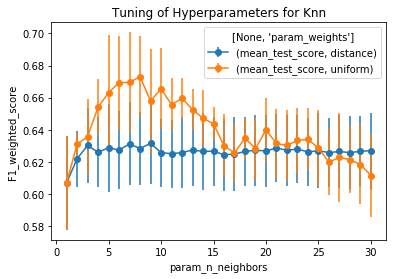

In [72]:
plot_results(grid_knn ,par_1 = "n_neighbors",par_2 = "weights", title = "Tuning of Hyperparameters for Knn", y_lab= "F1_weighted_score")

In [73]:
# Let's apply the model with our tuned hyperparamters
neigh = KNeighborsClassifier(n_neighbors=7)
y_pred_knn = neigh.fit(x_train, y_train).predict(x_test)

In [74]:
print(classification_report(y_test, y_pred_knn))

             precision    recall  f1-score   support

        acc       0.40      0.31      0.35        77
       good       0.42      0.36      0.38        14
      unacc       0.76      0.84      0.80       242
      vgood       0.17      0.08      0.11        13

avg / total       0.64      0.67      0.65       346



# Let's move to decision tree

In [75]:
# Using the same data set

In [77]:
# Gridsearch to determine tune the hyperparameters: max_depth and min_samples_leaf
depth={"max_depth":[1,5,10,15,20,25,30],
      "min_samples_leaf" : [10,20,30]}      

DTC=DecisionTreeClassifier()

grid_dt=GridSearchCV(DTC,param_grid=depth , cv=4, scoring= 'f1_weighted')
grid_dt.fit(x_train,y_train)
dt_result =pd.DataFrame(grid_dt.cv_results_)
grid_dt.best_params_

{'max_depth': 10, 'min_samples_leaf': 10}

In [78]:
#Let's apply the model with the best hyperparameters

final_dt = DecisionTreeClassifier(**grid_dt.best_params_)
y_pred_dt = final_dt.fit(x_train, y_train).predict(x_test)

In [79]:
print(classification_report(y_test, y_pred_dt))

             precision    recall  f1-score   support

        acc       0.49      0.62      0.55        77
       good       0.13      0.14      0.14        14
      unacc       0.82      0.79      0.80       242
      vgood       0.00      0.00      0.00        13

avg / total       0.69      0.70      0.69       346



# Finally, let's use SVM

In [80]:
# Using the same data set as before

In [83]:
# grid search to determine the best combination of hyperparameters: C and tol
# As logistic regression seems to be performing weel, it looks like the data 
# is linearly separable, so let's use the linear kernel
c_values = [0.01,0.1,1,10,100,1000]
tol_values = [0.0001,0.001,0.01,0.1]

param_grid = dict(C = c_values, tol = tol_values)

SVC_mod = svm.SVC(kernel = 'linear')
grid_svc = GridSearchCV(SVC_mod, param_grid, cv = 4, scoring = 'f1_weighted')
grid_svc.fit(x_train,y_train)
grid_svc.best_params_

{'C': 1000, 'tol': 0.01}

In [84]:
# Finally, let's apply svm with these hyperparameters
final_svc = svm.SVC(**grid_svc.best_params_)
y_pred_svc = final_svc.fit(x_train, y_train).predict(x_test)

In [85]:
print(classification_report(y_test, y_pred_svc))

             precision    recall  f1-score   support

        acc       0.47      0.51      0.49        77
       good       0.00      0.00      0.00        14
      unacc       0.79      0.79      0.79       242
      vgood       0.00      0.00      0.00        13

avg / total       0.66      0.66      0.66       346



Out of our 5 models, and based on the weighted average f1-score, Naive Bayes is the best model.
Regarding per-class performance, all the models share the fact that they perform better for the class 'unacc', which is
expected as that class represents 70% of the entire records of the dataset.
However, the final model that I'd suggest uis to use the decision tree as it doesn't assume anything about the data (non-parametric method)

In [85]:
df['class'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64